# 0.3.1 Comparing Accuracy Metrics

The accuracy results that we've been getting so far haven't reflected the those presented in O'Reilly's paper, so let's generate them more systematically.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Sat Mar 09 2019 19:34:19 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : 38a0a7a2722fde1a3509380782c605515e1e71bf
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import os
import logging
from functools import reduce

# Third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_MODELS

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

tf.logging.set_verbosity(logging.INFO)

### Global Variables

#### Combigen Task Variables

In [9]:
# Number of slots in a training set
STACK = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2
# Number of lines per axis
LINES = [1,1]

#### Data Parameters

In [10]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN= 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

In [11]:
# Training Data
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TRAIN = cg.inverse_transform(Y_TRAIN)
# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_VAL = cg.inverse_transform(Y_VAL)
# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [12]:
# Learning rate
ALPHA = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = STACK * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = STACK * SIZE * DIMS

#### Training Parameters

In [41]:
# Number of times to print an update
N_UPDATES = 5
# Which device to train on
TF_DEVICE = '/cpu:0'

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. Skip around as needed.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

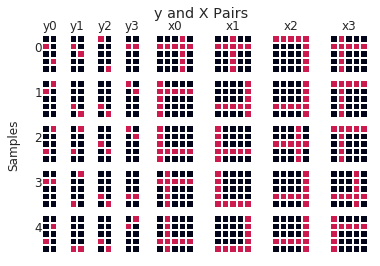

In [13]:
cgh.visualize_combigen(5)
plt.show()

### Previous Accuracy Results

Between nb-0.2.x and 0.3, our accuracy results have been quite reproducible. Here is a summary of the different results so far. All of the models shown below were trained using the O'Reilly BP architecture and binary cross-entropy as the loss. 

#### Elemental Accuracy

In nb-0.2.x, the O'Reilly BP model was implemented in keras using an absolute error based accuracy metric. Below is the training curve when trained to 5000 epochs.

![BCE_SGD](images/nb0.2.1_bce_sgd_5000_epochs.png)

#### Sample Accuracy

In nb-0.3, the model was implemented in tensorflow with a modification to the accuracy
Some things to note are that the models were trained to 10 times the number of epochs as O'Reilly did (500). However, a dotted vertical line was added at the 500 epoch mark to make it clear what the model's performance would have looked like.

## Obtaining the Metrics

This next section will define the computational graph that will be used to generate the metrics down below. It is largely code copied from nb-0.3, so skip around as needed.

In [14]:
# Cleanup any residual nodes
tf.reset_default_graph()

### Make the Datasets

Define the various `tf.Dataset`s that will be used.

In [19]:
def make_tf_datasets(init_ops):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    # Training dataset
    dataset_train = tf.data.Dataset.from_tensor_slices(
        (X_TRAIN, Y_TRAIN)).repeat().batch(BATCH_SIZE)
    # Validation dataset
    dataset_val = tf.data.Dataset.from_tensor_slices(
        (X_VAL, Y_VAL)).repeat().batch(N_VAL)
    # Testing dataset
    dataset_test = tf.data.Dataset.from_tensor_slices(
        (X_TEST, Y_TEST)).repeat().batch(N_TEST)
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    train_iter = dataset_train.make_initializable_iterator()
    # Validation iterator
    val_iter = dataset_val.make_initializable_iterator()
    # Testing iterator
    test_iter = dataset_test.make_initializable_iterator()
    # Aggregate the iterators
    iterators = [train_iter, val_iter, test_iter]

    # Add the initiatlizations to the init opts
    init_ops += [train_iter.initializer, val_iter.initializer, test_iter.initializer]
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, dataset_train.output_types, 
        dataset_train.output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

### TF Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [21]:
# Weights and biases
weights = {
    'h1': tf.get_variable(name='w_h1', shape=[N_INPUTS, N_HIDDEN_1],
                      initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable(name='w_out', shape=[N_HIDDEN_1, N_OUTPUTS],
                      initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'b1': tf.get_variable(name="b_1", shape=[N_HIDDEN_1], 
                      initializer=tf.zeros_initializer()),
    'out': tf.get_variable(name="b_out", shape=[N_OUTPUTS], 
                      initializer=tf.zeros_initializer()),
}

# List for initialization operations
init_ops = [tf.global_variables_initializer()]

### Model and Loss Function

The architecture is the same as previous notebooks. See nb-0.3 for more details.

In [22]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, STACK, SIZE, DIMS])

with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handle, init_ops = make_tf_datasets(init_ops)
    
    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=ALPHA)

    # train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    train_op = optimizer.minimize(loss_op)

### Metrics

The last few ops to define before training are the metrics. 

In [29]:
with tf.device(TF_DEVICE):
    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float16))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float16))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float16))

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [30]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Defining the Training Function

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [40]:
def train_or_model(sess, epochs=EPOCHS, n_updates=N_UPDATES):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'el_acc':[], 'ax_acc':[], 'sl_acc':[], 'sm_acc':[], 
               'val_loss':[], 'val_el_acc':[], 'val_ax_acc':[], 'val_sl_acc':[], 
               'val_sm_acc':[]}
    # Run the initialization ops
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run([i.string_handle() 
                                                                   for i in iterators])

    for epoch in range(epochs):
        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            _, ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [train_op, loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                feed_dict={handle: training_handle})
            
        # Get means for the epoch
        epoch_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))

        # Calculate validation accuracy and loss
        val_data = list(sess.run([loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                                 feed_dict={handle: validation_handle}))
        
        # Record
        for key, value in zip(metrics.keys(), epoch_data + val_data):
            metrics[key].append(value)

        # Selectively display the epoch number
        if not epoch % (epochs / n_updates) or epoch == epochs - 1:
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss   Sample Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                epoch+1, epochs, epoch_data[0],epoch_data[4], epoch_data[1], 
                val_data[0], val_data[4], val_data[1]))

    # Calculate accuracy for test images
    print("Optimization Finished! Testing Accuracy:", sess.run(
        accuracy_op, feed_dict={handle: testing_handle}))
    return metrics

### Getting Metrics for 10 Models

The last thing to do is encapsulate everything into one 

In [55]:
%%time
sess = new_session()
metrics_ = []
for i in range(10):
    print('Starting training for model {0}...'.format(i))
    metrics.append(train_or_model(sess, epochs=50*EPOCHS, n_updates=1))
    print('Completed training for model {0}!\n'.format(i))

Starting training for model 0...
Completed epoch 1/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.6657       0.0000       0.5955
    Validation:     0.6367       0.0000       0.6450

Completed epoch 25000/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.0025       1.0000       1.0000
    Validation:     0.0635       0.3999       0.9766

Optimization Finished! Testing Accuracy: 0.454
Completed training for model 0!

Starting training for model 1...
Completed epoch 1/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.7226       0.0000       0.5315
    Validation:     0.6821       0.0000       0.5732

Completed epoch 25000/25000. Metrics:
                     Loss   Sample Accuracy   Elem Accuracy
    Epoch:          0.0025       1.0000       1.0000
    Validation:     0.0618       0.4199       0.9771

Optimization Finished! Testing Accuracy: 0

## Plotting the Metrics

Just like before, let's plot the training curves using the metrics we obtained. To do this, let's borrow the same function from nb-0.3 but make it a bit more general.

In [ ]:
print(1)

In [ ]:
from leabratf.utils import as_list

def plot_metrics(metrics_inp, metrics=None, epochs=None):
    import ipdb;ipdb.set_trace()
    metrics_list = [metrics_inp] if isinstance(metrics_inp, dict) else list(metrics_inp)
    for metrics_dict in metrics_list:
        # Keep this working for keras
        metrics_dict = metrics_dict if not hasattr(metrics_dict, 'history') else metrics_dict.history
        # What metrics to plot
        metrics = metrics or metrics_dict.keys()
        # How many epochs to plot
        if not epochs:
            len_metrics = [len(val) for val in metrics_dict.values()]
            assert all(l == len_metrics[0] for l in len_metrics), 'Metrics have different lengths'
            epochs = len_metrics[0]
        # Plot each metric
        for key in metrics:
            plt.plot(metrics_dict[key][:epochs], label=key)
    plt.title('Training History')
    plt.xlabel('Epochs')
    if epochs > EPOCHS:
        plt.axvline(EPOCHS, linestyle='--', label='500 Epochs')
    plt.legend()
    
plot_metrics(metrics)
plt.show()

### The Legend

Now that we have so may metrics to keep track of, it's worth taking the time to define each of them.

#### Training Set Metrics

Metrics obtained every epoch from from performance on the training set.

- `loss` - Loss for the training set
- `el_acc` - Element-wise accuracy between predictions and labels for the training set
- `ax_acc` - Axis accuracy for each slot in each sample between predictions and labels for the training set. Score per sample goes in eighth steps between 0.0 and 1.0. Every correct axis in every slot contributes 0.125 to the the overall accuracy
- `sl_acc` - Slot accuracy for sample between predictions and labels for the training set. Score per sample goes in quarter steps between 0.0 and 1.0. Any slot that has all elements correct contributes 0.25 to the score
- `sm_acc` - Sample accuracy between predictions and labels for the training set. Score per sample is binary - model must get every element correct to receive 1.0

#### Validation Set Metrics

Metrics obtained every epoch from from performance on the validation set.

- `val_loss` - Loss for the validation set for a particular epoch
- `val_el_acc` - Element-wise accuracy between predictions and labels for the validation set. See above for details
- `val_sl_acc` - Slot accuracy for sample between predictions and labels for the validation set. See above for details
- `val_sm_acc` - Sample accuracy between predictions and labels for the training set. See above for details

### All Metrics

Let's plot the average of all the metrics in one plot just to see the general structure, so first get an average value dictionary.

In [78]:
metrics_ave = {key:np.mean([model[key] for model in metrics], axis=0) for key in metrics[0].keys()}

And now plot them all.

In [82]:
plot_metrics(metrics_ave)
plt.show()

AttributeError: 'str' object has no attribute 'keys'

## Accuracy Metrics in Detail

Let's go through each of the different accuracy metrics individually.

### Sample Accuracy

The first one to check out should be the sample accuracy since it's the one that seems the most similar to O'Reilly's definition of accuracy. So let's plot the sample accuracies of all the models.